In [2]:
%%time
from twython import Twython
from twython import TwythonError, TwythonRateLimitError, TwythonAuthError
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
import time
import datetime
import csv
#import nltk
#import nltk.tag.stanford as st
import ner
import pandas as pd
import numpy as np
import re
from pandas import ExcelWriter
from collections import defaultdict
from fuzzywuzzy import fuzz,process
import unicodecsv

CPU times: user 541 ms, sys: 603 ms, total: 1.14 s
Wall time: 1.66 s


/Users/jackiemartinez/anaconda/lib/python2.7/site-packages/fuzzywuzzy/fuzz.py:33: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [328]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
CONSUMER_KEY = 'VEW2a7ttqT7rUrfi88ql02rpd'
CONSUMER_SECRET ='susbqqPl1WU3C8d4jGgxaCUBebmYuPRXljwQr4N858FXyVCMFj'
OAUTH_TOKEN = '27459655-dGoeUZP6x92W7C97ZBp2kuZWnnFBDBfRmJgtD9fwS'
OAUTH_TOKEN_SECRET = 'nP7CfdiiIhvjzUlUg38qgVoR5nWjWqpv8NaIcxpMzY8Yp'

#auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,CONSUMER_KEY, CONSUMER_SECRET)
api = Twython(CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

In [5]:
full_tweet_css = ".js-stream-item.stream-item.stream-item.expanding-stream-item"
tweet_text_css = ".TweetTextSize.js-tweet-text.tweet-text"
timestamp_css = '.tweet-timestamp.js-permalink.js-nav.js-tooltip'
quote_tweet_css = ".QuoteTweet-text.tweet-text.u-dir"
rt_css = '.ProfileTweet-action--retweet.u-hiddenVisually'
fav_css = ".ProfileTweet-action--favorite.u-hiddenVisually"
action_css = '.ProfileTweet-actionCount'

In [3]:
team_list_full = ["DC Breeze","Cincinnati Revolution","Chicago Fire","Charlotte Express",
             "Atlanta Hustle","Detroit Mechanix","INDIANAPOLIS ALLEYCATS","Jacksonville Cannons",
             "LOS ANGELES AVIATORS","MADISON RADICALS","MINNESOTA WIND CHILL","MONTREAL ROYAL",
             "NASHVILLE NIGHTWATCH","New York Empire","Ottawa Outlaws","PHILADELPHIA PHOENIX",
             "PITTSBURGH THUNDERBIRDS","Raleigh Flyers","Rochester Dragons","SAN DIEGO GROWLERS",
             "SAN FRANCISCO FLAMETHROWERS","SAN JOSE SPIDERS","SEATTLE CASCADES","TORONTO RUSH",
             "VANCOUVER RIPTIDE"]
team_list_full = [t.lower() for t in team_list_full]
team_cities = ["dc","cincinnati","chicago","charlotte","atlanta","detroit","indianapolis",
               "jacksonville","los angeles","madison","minnesota","montreal","nashville",
               "new york","ottawa","philadelphia","pittsburgh","raleigh","rochester",
               "san diego","san francisco","san jose","seattle","toronto","vancouver"]
team_names = ['breeze','revolution','fire','express','hustle','mechanix',
              'alleycats','cannons','aviators','radicals','wind chill','royal',
              'nightwatch','empire','outlaws','phoenix','thunderbirds','flyers',
              'dragons','growlers','flamethrowers','spiders','cascades','rush','riptide']
alt_name = ["dc","cincy","chicago","charlotte","atlanta","detroit","indy",
            "jax","la","madison","minnesota","montreal","nashville",
            "ny","ottawa","philly","pittsburgh","raleigh","rochester",
            "sd","sf","sj","seattle","toronto","vancouver"]
team_dict = dict(zip(team_cities, zip(team_names,alt_name)))


In [78]:
for k,v in team_dict.iteritems():
    print k,v

charlotte ('express', 'charlotte')
madison ('radicals', 'madison')
cincinnati ('revolution', 'cincy')
san jose ('spiders', 'sj')
minnesota ('wind chill', 'minnesota')
ottawa ('outlaws', 'ottawa')
san francisco ('flamethrowers', 'sf')
seattle ('cascades', 'seattle')
rochester ('dragons', 'rochester')
chicago ('fire', 'chicago')
san diego ('growlers', 'sd')
philadelphia ('phoenix', 'philly')
new york ('empire', 'ny')
vancouver ('riptide', 'vancouver')
indianapolis ('alleycats', 'indy')
pittsburgh ('thunderbirds', 'pittsburgh')
nashville ('nightwatch', 'nashville')
dc ('breeze', 'dc')
atlanta ('hustle', 'atlanta')
jacksonville ('cannons', 'jax')
toronto ('rush', 'toronto')
detroit ('mechanix', 'detroit')
raleigh ('flyers', 'raleigh')
los angeles ('aviators', 'la')
montreal ('royal', 'montreal')


In [3]:
def get_tweets(query_str, min_unixtime):
    tweets = []
    driver = webdriver.Chrome()
    driver.set_window_size(500, 500)
    #pt2 = "%20until%3A2015-04-05&src=typd"
    url_to_get = "https://twitter.com/search?q=" + query_str #+ pt2
    print "URL TO GET: ", url_to_get
    #url_to_get = "https://twitter.com/search?q=" + query_str
    driver.get(url_to_get)
    
    while True:
        index = len(tweets)
        tweets_whole = driver.find_elements_by_css_selector(full_tweet_css)[index:]
        for elt in tweets_whole:
            # get tweet text
            try:
                t_text = elt.find_element_by_css_selector(tweet_text_css).text
            except NoSuchElementException:
                print "WARNING: No Text Element around: ", index
                t_text = "ERROR: no text element found"
            # get tweet timestamp
            try:
                t_unixtime = (int(elt.find_element_by_css_selector(timestamp_css)
                          .find_element_by_css_selector("span")
                          .get_attribute("data-time")))
            except NoSuchElementException:
                print "WARNING: No Time Element around: ", index
                #t_unixtime = elt.get_attribute('innerHTML')
                # defaults to 1/1/2016 (impossible, so it will show up as a red flag in the data)
                t_unixtime = 1451606400
            # get any quoted tweets within the tweet
            try:
                t_quote_text = elt.find_element_by_css_selector('.QuoteTweet-text.tweet-text.u-dir').text
                quote_tup = (t_quote_text, t_unixtime, 0)
                tweets.append(quote_tup)
            except NoSuchElementException:
                pass
            # get sum of RTs and favorites
            try:
                rts = (elt
                       .find_element_by_css_selector(rt_css)
                       .find_element_by_css_selector(action_css)
                       .get_attribute("data-tweet-stat-count"))
                favs = (elt
                       .find_element_by_css_selector(fav_css)
                       .find_element_by_css_selector(action_css)
                       .get_attribute("data-tweet-stat-count"))
                rts_plus_favs = int(rts) + int(favs)
            except NoSuchElementException:
                rts_plus_favs = 0
            tweet_tup = (t_text,t_unixtime,rts_plus_favs)
            tweets.append(tweet_tup)
        if int(tweets[-1][1]) < min_unixtime:
            print "FINISHED, WITH LAST TWEET AT: ", tweets[-1][1]
            driver.quit()
            return(tweets)
        print "Most Recent Unix Time: ", int(tweets[-1][1])
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)
    driver.quit()

In [6]:
%%time
#tweets = get_tweets("audl", 1420070400)
tweet_grab = get_tweets("audl", 1420070400)

URL TO GET:  https://twitter.com/search?q=audl
Most Recent Unix Time:  1448982374
Most Recent Unix Time:  1448459812
Most Recent Unix Time:  1447700045
Most Recent Unix Time:  1447118607
Most Recent Unix Time:  1446677072
Most Recent Unix Time:  1446278132
Most Recent Unix Time:  1445969764
Most Recent Unix Time:  1444941006
Most Recent Unix Time:  1444351291
Most Recent Unix Time:  1444236727
Most Recent Unix Time:  1443645603
Most Recent Unix Time:  1443112062
Most Recent Unix Time:  1442591581
Most Recent Unix Time:  1442251047
Most Recent Unix Time:  1441740726
Most Recent Unix Time:  1441123319
Most Recent Unix Time:  1440874246
Most Recent Unix Time:  1440771014
Most Recent Unix Time:  1440628329
Most Recent Unix Time:  1440212327
Most Recent Unix Time:  1439959783
Most Recent Unix Time:  1439590362
Most Recent Unix Time:  1439333131
Most Recent Unix Time:  1439214343
Most Recent Unix Time:  1439162851
Most Recent Unix Time:  1439161113
Most Recent Unix Time:  1439152667
Most Rec

In [7]:
print len(tweet_grab)

2120


In [12]:
## Write to file
# with open('audl_tweets.csv','w') as out:
#     csv_out=csv.writer(out)
#     csv_out.writerow(['tweet_text','tweet_unixtime', 'tweet_popularity'])
#     for row in tweet_grab:
#         new_tup = (row[0].encode("utf8"), row[1], row[2])
#         csv_out.writerow(new_tup)

In [18]:
df = pd.read_excel('audl_tweets.xls')

In [19]:
df.shape

(2085, 3)

In [20]:
df.head()

,tweet_text,tweet_unixtime,tweet_popularity
0,Recruit Camp #1 tonight! http://cincinnatirevo...,1449359003,8
1,"Sin The Fields: Rochester Dragons, AUDL Advice...",1449262946,0
2,New STF! This time we tried the strategy of no...,1449258052,1
3,".@SinTheFields: Rochester Dragons, @theAUDL Ad...",1449257125,4
4,We're making the storyboard for the 2016 #AUDL...,1449180084,9


In [21]:
#take away new lines
df['tweet_text'] = df['tweet_text'].apply(lambda x: re.sub(r'\n',' ',x))

In [22]:
for elt in df.tweet_text:
    print type(elt
    print "--"

Recruit Camp #1 tonight! http://cincinnatirevolution.com/2016-revolution-tryouts/ â€¦ #AUDL #cincy #ultimate 
--
Sin The Fields: Rochester Dragons, AUDL Advice, & Reader Mail http://ow.ly/38Gt7K 
--
New STF! This time we tried the strategy of not releasing it 10 mins before a global tragedy! (finger's crossed) http://ultiworld.com/2015/12/04/sin-the-fields-rochester-dragons-audl-advice-reader-mail/ â€¦ â€¦
--
.@SinTheFields: Rochester Dragons, @theAUDL Advice, & Reader Mail: http://ultiworld.com/2015/12/04/sin-the-fields-rochester-dragons-audl-advice-reader-mail/ â€¦
--
We're making the storyboard for the 2016 #AUDL mag. What do you want to see in it? 
--
What a pro looks like. #AUDL #SOTG 
--
#ultimate AUDL November News Roundup - There has been a lot going on in the offseason for the American Ultimate... http://ow.ly/38DDGE 
--
.@theAUDL November News Roundup: http://ultiworld.com/2015/12/03/audl-november-news-roundup/ â€¦
--
Today is International Spirit of the Game Day: Celebrate t

In [124]:
## Extract user mentions
def get_username_set(all_tweets_text):
    username_set = []
    for tweet_text in all_tweets_text:
        users = re.findall(r'@(\w+)', tweet_text)
        username_set.extend(users)
    #user_set = set(user_set)
    return set(username_set)
## Finds users' names based on list of usernames -- USES TWITTER API!!!
def get_names(usernames,twitter_instance):
    user_dict = {}
    indexes = range(0,len(usernames),100)
    indexes.append(len(usernames) - 1)
    for i in range(len(indexes) - 1):
        u_list = usernames[indexes[i]:indexes[i+1]]
        print (indexes[i]),(indexes[i+1])
        u_csv = ','.join(u_list)
        #print u_csv
        res_dicts = twitter_instance.lookup_user(screen_name = u_csv)
        for elt in res_dicts:
            user_dict[elt['screen_name'].lower()] =elt['name'].title()
    return user_dict



In [125]:
uname_set = get_username_set(df.tweet_text)

In [126]:
list(uname_set)[len(uname_set) - 1]

u'ditcheverything'

In [127]:
username_dict = get_names(list(uname_set),api)

0 100
100 200
200 300
300 400
400 441


In [128]:
len(username_dict.keys())

409

In [139]:
# Write Dictionary to File
w = csv.writer(open("username_dict.csv", "w"))
for key, val in username_dict.items():
    w.writerow([key, val.encode('utf-8')])

In [130]:
def replace_username(old_tweet,name_dict):
    for user in re.findall(r'@(\w+)', old_tweet):
        try:
            nm = name_dict[user.lower()]
        except KeyError:
            print "User not found: ", user
            nm = user
        old_tweet = re.sub(user,nm,old_tweet)
    nt = re.sub(r'@','',old_tweet)
    return(nt)

In [132]:
df['tweet_text'] = df['tweet_text'].apply(lambda x: replace_username(x,username_dict))

User not found:  ditcheverything
User not found:  GDPJ_Meyer
User not found:  CincySaints
User not found:  charlotteexpress
User not found:  56ersNPSL
User not found:  charlotteaudl
User not found:  Bolton_Lava
User not found:  CharlotteAUDL


In [146]:
## Save work up to this point:
writer = ExcelWriter('audl_df.xlsx')
df.to_excel(writer,'Sheet1')
writer.save()

##Open Files from Directory
df: audl_df.xlsx

dictionary: username_dict.csv

In [4]:
df = pd.read_excel('audl_df.xlsx')
username_dict = {}
reader = csv.reader(open("username_dict.csv"))
for row in reader:
    username_dict[row[0]]=row[1:]

In [5]:
# s2 = 'Sin The Fields: Rochester Dragons,  Advice, & Reader Mail http://ow.ly/38Gt7K '
# clean_tweets_2(s2)

In [6]:
# s3 = df.tweet_text[1148]
# print s3
# clean_tweets_2(s3)

In [7]:
not_names = ['audl','ultiworld','mlu','sotg']
def clean_tweets_2(t):
    potential_teams = []
    pat = ('|'.join(not_names))
    t = re.sub('(?i)'+pat,'',t)
    t = re.sub('#','',t)
    for k,v in team_dict.iteritems():
        if k in t.lower() or v[0] in t.lower() or (' ' + v[1] + ' ') in t.lower():
            pat = '|'.join([k,v[0],(' ' + v[1] + ' ')])
            t = re.sub('(?i)' + pat,'',t)
            potential_teams.append(k)
    return (potential_teams,t)

In [8]:
res_clean = df['tweet_text'].apply(clean_tweets_2)
df['clean'] = [twt for (team,twt) in res_clean]
df['poss_team'] = [team for (team,twt) in res_clean]


In [9]:
df.head()

,tweet_text,tweet_unixtime,tweet_popularity,clean,poss_team
0,Recruit Camp #1 tonight! http://cincinnatirevo...,1449359003,8,Recruit Camp 1 tonight! http://.com/2016--tryo...,[cincinnati]
1,"Sin The Fields: Rochester Dragons, AUDL Advice...",1449262946,0,"Sin The Fields:, Advice, & Reader Mail http:/...",[rochester]
2,New STF! This time we tried the strategy of no...,1449258052,1,New STF! This time we tried the strategy of no...,[rochester]
3,".Sinthefields: Rochester Dragons, Audl Advice,...",1449257125,4,".Sinthefields:, Advice, & Reader Mail: http:/...",[rochester]
4,We're making the storyboard for the 2016 #AUDL...,1449180084,9,We're making the storyboard for the 2016 mag....,[]


In [10]:
# Run in different terminal before executing code below
# java -mx1000m -cp stanford-ner.jar edu.stanford.nlp.ie.NERServer \
#     -loadClassifier classifiers/english.all.3class.caseless.distsim.crf.ser.gz \
#     -port 8080 -outputFormat inlineXML
tagger = ner.SocketNER(host='localhost', port=8080)

In [11]:
def process_tweet(twt,pop,poss_team,dpop,dteam):
    try:
        persons = tagger.get_entities(twt)['PERSON']
    except KeyError:
        persons = []
    for p in persons:
        if len(p.split()) == 4:
            if p.split()[0] == p.split()[2] and p.split()[1]==p.split()[3]:
                p = ' '.join(p.split()[0:2])
        dpop[p.lower()] += pop + 1
        dteam[p.lower()].extend(poss_team)

In [12]:
name_dict =  defaultdict(int)
poss_team_dict = defaultdict(list)
#apply function over dataframe to modify dictionary
dummy_var = df.apply(lambda r: process_tweet(r.clean, r.tweet_popularity, r.poss_team
                                             ,name_dict, poss_team_dict)
                     ,axis=1)


In [176]:
sorted(name_dict.items(), key=lambda x:x[0], reverse=True)

[(u'\u0153richard dana', 2),
 (u'zane rankin', 9),
 (u'zach braun', 2),
 (u'yiding hou', 2),
 (u'yah', 2),
 (u'xtian guerrero', 3),
 (u'xtehn titcomb', 10),
 (u'xavier payne', 3),
 (u'wrigley', 2),
 (u'wissel', 7),
 (u'wilson gardner', 19),
 (u'william rains', 3),
 (u'will evan lepler', 3),
 (u'wildwood  nomnomnom flyinghometotexas', 3),
 (u'wildweekend', 15),
 (u'white', 3),
 (u'westcoastbestcoast', 5),
 (u'watson', 3),
 (u'watchespn', 1),
 (u'wareagle', 10),
 (u'von jonas', 1),
 (u'veronique', 1),
 (u'vasilyev', 6),
 (u'vanessa tan', 1),
 (u'vamos jugar al frisbi', 2),
 (u'ultimatefrisbee wfdf', 2),
 (u'ultimatefrisbee  gopro', 53),
 (u'ultimatefrisbee', 15),
 (u'ucsantacruz', 1),
 (u'tyler kinley', 3),
 (u'tyler degirolamo', 62),
 (u'tyler', 5),
 (u'ty', 48),
 (u'turnup', 4),
 (u'tunnell', 1),
 (u'tsu', 5),
 (u'tsn', 2),
 (u'trevor purdy', 1),
 (u'travis m. carpenter mintultimate', 10),
 (u'travis m. carpenter', 2),
 (u'tormey chuck', 3),
 (u'tong', 2),
 (u'tom raliffe', 19),
 (u'to

In [120]:
poss_team_dict['tim']

['cincinnati', 'cincinnati']

In [121]:
roster_dict = {}
reader = csv.reader(open("combined_dict.csv"))
for row in reader:
    roster_dict[row[0]]=row[1:]

In [184]:
roster_dict = {}
def unicode_csv_reader(utf8_data, dialect=csv.excel, **kwargs):
    csv_reader = csv.reader(utf8_data, dialect=dialect, **kwargs)
    for row in csv_reader:
        yield [unicode(cell, 'utf-8') for cell in row]

filename = 'combined_dict.csv'
reader = unicode_csv_reader(open(filename))

In [185]:
for row in reader:
    roster_dict[row[0]]=row[1:]

In [186]:
v = [v[0].lower() for v in roster_dict.values()]
roster_dict2 = dict(zip(v,roster_dict.keys()))
#roster_dict['Frédérick Parenteau']

In [187]:
roster_dict2[u'André Arsenault']

KeyError: u'Andr\xe9 Arsenault'

In [188]:
len(roster_dict2.keys())

780

In [189]:
#sorted(name_dict.keys())

In [190]:
len(roster_dict.keys())

789

In [235]:
choices = [k.lower() for k in (roster_dict2.keys())]
# p = 'xtehn'
# process.extract(p, choices, limit=10)
#name_dict

In [229]:
one_name = {}
two_name = defaultdict(int)
n_name = {}
choices = [k.lower() for k in (roster_dict2.keys())]

for k,v in name_dict.iteritems():
    if len(k.split()) == 2:
        try:
            match = process.extract(k,choices,limit=2)
        except UnicodeDecodeError:
            print "unicode decode error"
            match = (k,0)
        if match[0][1]>95:
            two_name[match[0][0]] += v
            
#     elif len(k.split()) % 2 == 0 and len(k.split()) > 2:
#         interval = range(0,len(k),2)
#         for i,intval in enumerate(interval):
            
#         two_name[k] = v
#     elif len(k.split()) > 2:
#         n_name[k] = v
#     else:
#         print "Error"

In [240]:
w = csv.writer(open("res_twitter_dict.csv", "w"))
for key, val in two_name.items():
    w.writerow([key, val])

In [307]:
print len(two_name)
#sorted(two_name.items(), key=lambda x:x[0], reverse=True)
#print sum(two_name.values())

110


In [250]:
two_name_dict = {}
reader = csv.reader(open("res_twitter_dict.csv"))
for row in reader:
    two_name_dict[row[0]]=int(row[1])

In [309]:
print len(two_name_dict)

110


# Start Data Analysis

In [91]:
def clean_df(df):
    """Removes rows with improperly formatted data
    
    df: pandas dataframe with throw-by-throw data
    
    returns: pandas df"""
    
    df = df[pd.isnull(df["Player 2"]) == False]
    return df[pd.isnull(df["Player 1"]) == False]

def get_players(df):
    """returns list of all players present in throw-by throw pandas dataframe"""
    players = pd.unique(df.loc[0:, "Player 0": "Player 27"].values.ravel())
    return [player for player in players if not pd.isnull(player)]

def summarize_points(df):
    """Gives point-by-point summaries
    
    df: pandas dataframe throw-by-throw data
    
    returns: pandas dataframe"""
    
    return df.groupby(["Date/Time", "Our Score - End of Point", "Their Score - End of Point"]).last().reset_index() 

In [95]:
def player_summaries(df):
    """Summarize statistics for all players
    
    df: pandas dataframe with throw-by-throw data
    
    returns: pandas dataframe"""
    
     # does not mutate the original
    df = clean_df(df)
    
    players = get_players(df)
    stats = {"team"      : "",
             "goals"     : 0,
             "assists"   : 0,
             "ds"        : 0,
             "throwaways": 0,
             "drops"     : 0,
             "opoints"   : 0,
             "dpoints"   : 0}
    team_stats = {player: dict(stats) for player in players}
    
    # to keep track of the column number
    cols = list(df.columns)
    passer   = cols.index("Passer")
    receiver = cols.index("Receiver")
    p0       = cols.index("Player 0")
    p27      = cols.index("Player 27")
    line     = cols.index("Line")
    
    
    # add goals and assists
    ogoals = df[(df.Action == "Goal") & (df["Event Type"] == "Offense")]
    for row in ogoals.values:
        # we have try/execpt here for unpredictable data impurities
        # eg: "Anonymous" for one of the assists, stat-keeper must
        # have not known who threw it (?) callahan?
        try: team_stats[row[passer]]["assists"] += 1
        except: pass
        try: team_stats[row[receiver]]["goals"]  += 1
        except: pass
        
    # add D's
    ds = df.Defender[df.Action == "D"]
    for player in ds:
        try: team_stats[player]["ds"] += 1
        except: pass
        
        
    # add turnovers and drops
    turns = df[((df.Action == "Throwaway") & (df["Event Type"] == "Offense")) | (df.Action == "Drop") ]
    for row in turns.values:
        if row[8] == "Throwaway":
            try: team_stats[row[passer]]["throwaways"] += 1
            except: pass
        else:
            try: team_stats[row[receiver]]["drops"]     += 1
            except: pass
    
    # add points
    point_summaries = summarize_points(df)
    line = list(point_summaries.columns).index("Line")
    for row in point_summaries.values:
        player_cols = row[p0:p27]
        players = [player for player in player_cols if not pd.isnull(player)]
        if row[line] == "O":
            for player in players:
                team_stats[player]["opoints"] += 1
        else:
            for player in players:
                team_stats[player]["dpoints"] += 1
                
    summary = pd.DataFrame.from_dict(team_stats, orient="index")
    summary = summary[["team", "goals", "assists", "ds", "throwaways", "drops", "opoints", "dpoints"]]
    summary["totalpoints"] = summary["opoints"] + summary["dpoints"]
    summary["pct_opoints"] = summary["opoints"] / [float(x) for x in summary["totalpoints"]]
    summary["pct_goal"]    = summary["goals"]   / [float(x) for x in summary["totalpoints"]]
    summary["pct_assist"]  = summary["assists"] / [float(x) for x in summary["totalpoints"]]
    summary["pct_d"]       = summary["ds"]      / [float(x) for x in summary["totalpoints"]]
    
    return summary

In [212]:
comb_df = pd.read_csv('combined.csv')
raleigh = pd.read_csv("South/RaleighFlyers2015-stats.csv")
play_sum = player_summaries(comb_df)

In [213]:
play_sum = play_sum.reset_index()

In [252]:
play_sum.head()

,index,team,goals,assists,ds,throwaways,drops,opoints,dpoints,totalpoints,pct_opoints,pct_goal,pct_assist,pct_d,name
0,A Brown,,8,24,6,0,5,187,26,213,0.877934,0.037559,0.112676,0.028169,andrew brown
1,A Drews,,11,27,8,0,1,43,172,215,0.200000,0.051163,0.125581,0.037209,adam drews
2,A Mesh,,39,34,35,0,6,74,321,395,0.187342,0.098734,0.086076,0.088608,andrew meshnick
3,A Olsen,,5,3,6,0,1,7,117,124,0.056452,0.040323,0.024194,0.048387,anders olsen
4,A-K Ian,,2,5,1,0,2,59,7,66,0.893939,0.030303,0.075758,0.015152,ian andre-knudsen


In [195]:
def to_roster_name(name,roster):
    try:
        n = roster[name][0]
    except KeyError:
        n = 'none'
    return n.lower()

def get_pop(name, roster,binary=True):
    try:
        r = roster[name.lower()]
        if binary:
            res = (r > 0) * 1
        else:
            res = r
    except KeyError:
        res = 0
    return res

In [253]:
two_name

defaultdict(<type 'int'>, {u'mike pannone': 6, u'paul lally': 19, u'jacob baumer': 2, u'leo pepper': 1, u'russell wynne': 2, u'sean mott': 31, u'kevin brown': 1, u'glenn poole': 1, u'brian moore': 5, u'nick haser': 4, u'kegan carroll': 6, u'nick lance': 32, u'andrew roca': 4, u'marcelo sanchez': 8, u'alex nord': 5, u'eric lissner': 1, u'steve mogielski': 20, u'husayn carnegie': 44, u'greg cohen': 12, u'chris larocque': 20, u'steve armitage': 21, u'scott richgels': 12, u'david berg': 16, u'trevor purdy': 1, u'bob liu': 5, u'dan bellinger': 6, u'tom allen': 3, u'tyler degirolamo': 62, u'simon higgins': 9, u'jeff silverman': 4, u'keenan plew': 5, u'keegan north': 1, u'tyler kinley': 3, u'mason gardner': 3, u'david janssen': 1, u'matt rehder': 10, u'jarnail bajwa': 1, u'jimmy mickle': 74, u'micah hood': 16, u'casey wu': 22, u'andy barnhart': 10, u'mark lloyd': 1, u'tim debyl': 22, u'kurt gibson': 12, u'jesse bolton': 16, u'matt smith': 80, u'colin grandon': 47, u'gus misleh': 2, u'brett pe

In [312]:
play_sum['name'] = play_sum['index'].apply(lambda x: to_roster_name(x,roster_dict))
play_sum['b_twitter'] = play_sum['name'].apply(lambda x: get_pop(x, two_name_dict))

In [314]:
np.sum(play_sum['b_twitter'])

49

In [318]:
list(play_sum.columns.values)

['index',
 'team',
 'goals',
 'assists',
 'ds',
 'throwaways',
 'drops',
 'opoints',
 'dpoints',
 'totalpoints',
 'pct_opoints',
 'pct_goal',
 'pct_assist',
 'pct_d',
 'name',
 'b_twitter']

In [321]:
STANDARDIZABLE = ['goals','assists','ds','throwaways','drops','opoints','dpoints','totalpoints']
dftouse = play_sum

In [322]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.7)
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [324]:
from sklearn.preprocessing import StandardScaler
for col in STANDARDIZABLE:
    print col
    valstrain=dftouse[col].values[mask]
    valstest=dftouse[col].values[~mask]
    scaler=StandardScaler().fit(valstrain)
    outtrain=scaler.transform(valstrain)
    outtest=scaler.fit_transform(valstest)
    out=np.empty(mask.shape[0])
    out[mask]=outtrain
    out[~mask]=outtest
    dftouse[col]=out

goals
assists
ds
throwaways
drops
opoints
dpoints
totalpoints


/Users/jackiemartinez/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:498: UserWarning: StandardScaler assumes floating point values as input, got int64
  "got %s" % (estimator, X.dtype))


In [341]:
ccols = STANDARDIZABLE
ccols

['goals',
 'assists',
 'ds',
 'throwaways',
 'drops',
 'opoints',
 'dpoints',
 'totalpoints']

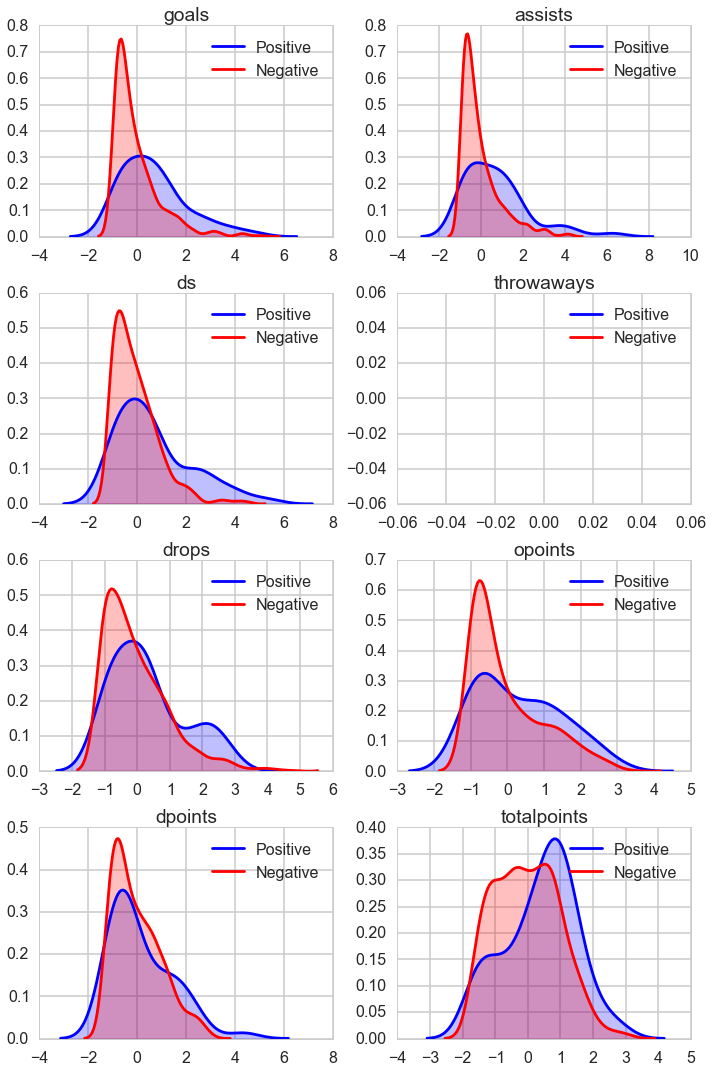

In [345]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 15), 
                         tight_layout=True)
for ax, cc in zip(axes.ravel(), ccols):
    sns.kdeplot(dftouse[dftouse["b_twitter"]==1][cc], ax=ax, c='b', shade=True, label = "Positive")
    sns.kdeplot(dftouse[dftouse["b_twitter"]==0][cc], ax=ax, c='r', shade=True, label="Negative")
    ax.set_title(cc)

In [334]:
# sum_l = []
# sum_k = []
# for n in play_sum['name']:
#     try:
#         sum_l.append(two_name_dict[n])
#     except KeyError:
#         sum_k.append(n)
# play_sum['name']

In [349]:
lcols = ccols
from sklearn.svm import LinearSVC
clfsvm=LinearSVC(loss="hinge")
Cs=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
Xmatrix=dftouse[ccols].values
Yresp=dftouse['b_twitter'].values

In [350]:
Xmatrix_train=Xmatrix[mask]
Xmatrix_test=Xmatrix[~mask]
Yresp_train=Yresp[mask]
Yresp_test=Yresp[~mask]

In [351]:
from sklearn.grid_search import GridSearchCV
parameters = {"C":Cs}
gridclassifier=GridSearchCV(clfsvm, param_grid=parameters, cv=5, scoring="accuracy")
gridclassifier.fit(Xmatrix_train, Yresp_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='accuracy', verbose=0)

In [352]:
best_c = gridclassifier.best_params_
best_sc = gridclassifier.best_score_
best = gridclassifier.best_estimator_
print best_c
print best_sc
print best

{'C': 0.01}
0.939226519337
LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)


In [353]:
new_clfsvm = best.fit(Xmatrix_train, Yresp_train)
new_clfsvm.score(Xmatrix_train, Yresp_train)

0.93922651933701662

In [354]:
"""
Function
--------
cv_optimize

Inputs
------
clf : an instance of a scikit-learn classifier
parameters: a parameter grid dictionary thats passed to GridSearchCV (see above)
X: a samples-features matrix in the scikit-learn style
y: the response vectors of 1s and 0s (+ives and -ives)
n_folds: the number of cross-validation folds (default 5)
score_func: a score function we might want to pass (default python None)
   
Returns
-------
The best estimator from the GridSearchCV, after the GridSearchCV has been used to
fit the model.
     
Notes
-----
see do_classify and the code below for an example of how this is used
"""
#your code here
def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best


In [363]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    #print type(clf)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [364]:
clfsvm, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, dftouse,lcols, u'b_twitter',1, mask=mask)

using mask
BEST {'C': 0.01} 0.939226519337 [mean: 0.92818, std: 0.01046, params: {'C': 0.001}, mean: 0.93923, std: 0.00424, params: {'C': 0.01}, mean: 0.93923, std: 0.00424, params: {'C': 0.1}, mean: 0.93923, std: 0.00424, params: {'C': 1.0}, mean: 0.93923, std: 0.00424, params: {'C': 10.0}, mean: 0.93923, std: 0.00424, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.94
Accuracy on test data:     0.93
[[218   0]
 [ 16   0]]
########################################################


/Users/jackiemartinez/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [357]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

In [358]:
print "whole data set", dftouse['b_twitter'].mean()#Highly asymmetric
print "training set", dftouse['b_twitter'][mask].mean(), "test set", dftouse['b_twitter'][~mask].mean()


whole data set 0.0630630630631
training set 0.060773480663 test set 0.0683760683761


So, given that only 6% of our results are twitter mentions anyway, the baseline model will be one that predicts that no one is popular and thus has 94% accuracy

In [359]:
ypred=clfsvm.predict(Xtest)
confusion_matrix(ytest, ypred)

array([[218,   0],
       [ 16,   0]])

In [366]:
clfsvm.coef_

array([[  1.26824438e-12,   2.16257379e-12,  -9.19849693e-13,
          0.00000000e+00,  -3.34429366e-13,  -1.70530688e-12,
          8.98550354e-13,  -8.61363142e-13]])

In [333]:
# two_name_res = {}
# for k,v in two_name_dict.iteritems():
#     k2=roster_dict2[k]
#     two_name_res[k2] = v

# two_name_res

In [332]:
# sum_ = 0
# for n in play_sum['index']:
#     if n in two_name_res.keys():
#         sum_ += 1
#     else:
#         print n
# names_in_tab = [p.lower() for p in play_sum['index']]

# for n in two_name_res.keys():
#     if n.lower() in names_in_tab:
#         print "yes"
#     else:
#         print n

In [329]:
# for name in two_name_res:
#     print name

In [331]:
# play_sum[play_sum['index'][0]=='K']
# play_sum.loc['inde']


In [167]:
# (two_name['alexan n'] == 1) * 1

0